# Diameter of Onion Bulb

In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


### Get the data
using pandas we load our dataset locally:

In [59]:
raw_dataset = pd.read_csv('G_datasets_NFT.csv')

In [60]:
dataset = raw_dataset.copy()
dataset.tail()

,Temp,WC,NL,N(UC),Fe(UC),B(UC),Diameter of Bulb
86,29.5,14.13,13.58,7.06,38.61,14.25,97.14
87,27.9,14.42,13.62,6.90,38.74,14.36,97.48
88,27.1,14.83,13.69,6.84,39.28,14.44,98.85
89,26.1,14.96,13.71,6.75,39.31,14.53,99.14
90,26.9,15.19,13.75,6.72,39.81,14.75,100.08


### Clean the data

The dataset contains a few unknown values:

In [61]:
dataset.isna().sum()

Temp                0
WC                  0
NL                  0
N(UC)               0
Fe(UC)              0
B(UC)               0
Diameter of Bulb    0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [62]:
dataset = dataset.dropna()

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [65]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the Number of Leaves (NL) is a function of all the other parameters. The other rows indicate they are functions of each other.

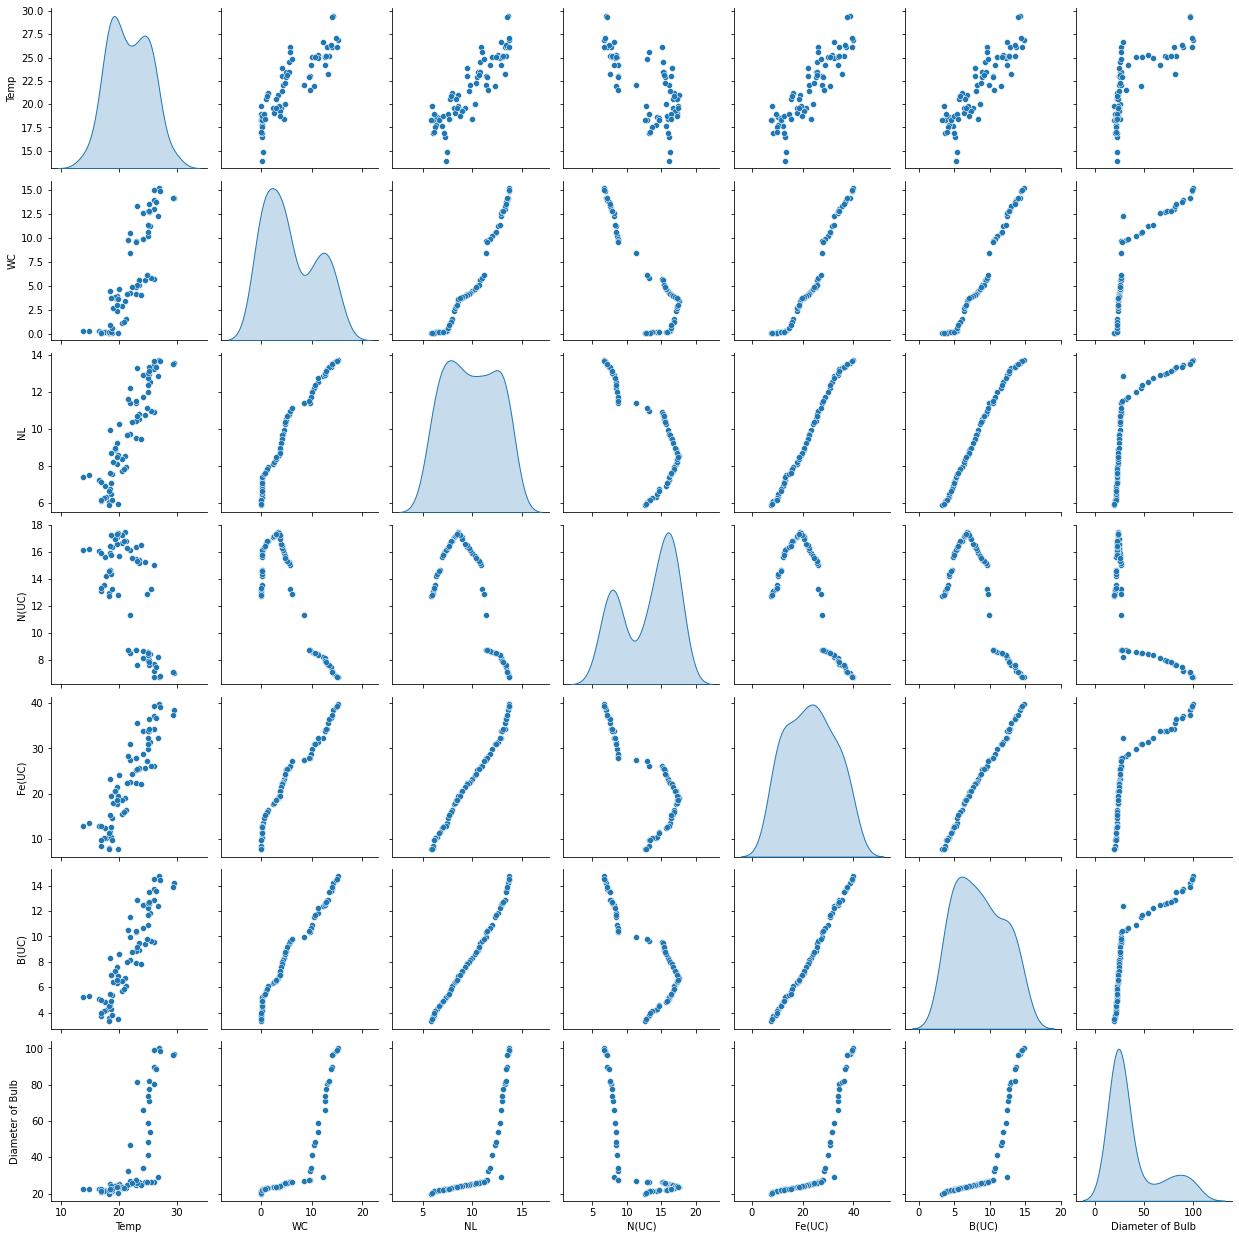

In [66]:
sns.pairplot(train_dataset[['Temp','WC','NL','N(UC)','Fe(UC)','B(UC)','Diameter of Bulb']],diag_kind='kde')

Let's see the overall statistics. 

In [67]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,73.0,21.749315,3.490229,13.90,18.90,21.50,25.00,29.50
WC,73.0,5.819452,5.063356,0.09,0.90,4.29,10.53,15.19
NL,73.0,9.874932,2.535820,5.88,7.62,9.73,12.25,13.75
N(UC),73.0,12.986712,3.828974,6.72,8.51,14.59,16.28,17.47
Fe(UC),73.0,22.999452,9.361504,7.64,15.26,22.57,30.88,39.81
B(UC),73.0,8.523562,3.372369,3.30,5.50,8.16,11.57,14.75
Diameter of Bulb,73.0,37.776849,25.125290,19.98,22.74,25.06,41.41,100.08


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [68]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Diameter of Bulb')
test_labels = test_features.pop('Diameter of Bulb')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [69]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Temp,21.749315,3.490229
WC,5.819452,5.063356
NL,9.874932,2.535820
N(UC),12.986712,3.828974
Fe(UC),22.999452,9.361504
B(UC),8.523562,3.372369
Diameter of Bulb,37.776849,25.125290


It is good practice to normalize features that use different scales and ranges.
One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.
normalization makes training much more stable.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [70]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [71]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [72]:
print(normalizer.mean.numpy())

[[21.749  5.819  9.875 12.987 22.999  8.524]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [73]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[18.3   0.11  6.05 12.93  7.83  3.6 ]]

Normalized: [[-1.   -1.14 -1.52 -0.01 -1.63 -1.47]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression with one variable

Begin with a single-variable linear regression to predict `'Diameter of Bulb'` from `'Number of Leaves(NL)'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in your single-variable linear regression model:

- Normalize the `'Number of Leaves(NL)'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'NL'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `NL` data:

In [74]:
NL = np.array(train_features['NL'])

NL_normalizer = layers.Normalization(input_shape=[1,], axis=None)
NL_normalizer.adapt(NL)

Build the Keras Sequential model:

In [75]:
NL_model = tf.keras.Sequential([
    NL_normalizer,
    layers.Dense(units=1)
])

NL_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'Diameter of Bulb'` from `'Number of Leaves'`.

Run the untrained model on the first 5 'NL' values. The output won't be good, but notice that it has the expected shape of `(5, 1)`:

In [76]:
NL_model.predict(NL[:5])

array([[-0.514],
       [-0.394],
       [ 0.118],
       [-0.049],
       [ 0.498]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

In [77]:
NL_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras `Model.fit` to execute the training for 100 epochs:

In [78]:
%%time
history = NL_model.fit(
    train_features['NL'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 1.83 s


Visualize the model's training progress using the stats stored in the `history` object:

In [79]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,16.282227,31.456554,95
96,16.112026,31.225231,96
97,15.925836,30.998409,97
98,15.745401,30.776878,98
99,15.572175,30.554518,99


In [80]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 200])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Diameter of Bulb]')
  plt.legend()
  plt.grid(True)

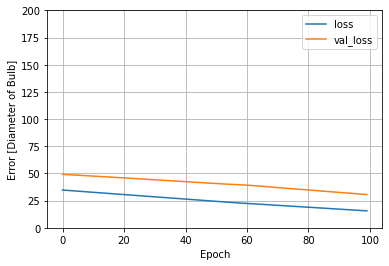

In [81]:
plot_loss(history)

Collect the results on the test set for later:

In [82]:
test_results = {}

test_results['NL_model'] = NL_model.evaluate(
    test_features['NL'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [83]:
x = tf.linspace(0.0, 20, 25)
y = NL_model.predict(x)

In [84]:
def plot_NL(x, y):
  plt.scatter(train_features['NL'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('NL')
  plt.ylabel('Diameter of Bulb')
  plt.legend()

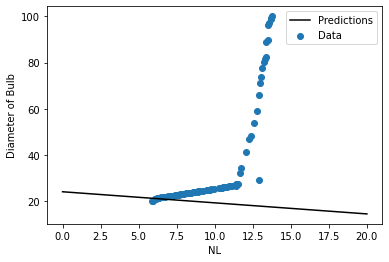

In [85]:
plot_NL(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [86]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [87]:
linear_model.predict(train_features[:5])

array([[ 1.395],
       [ 1.196],
       [ 0.256],
       [ 0.74 ],
       [-1.694]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(6, 1)`:

In [88]:
linear_model.layers[1].kernel

<tf.Variable 'dense_9/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[ 0.411],
       [ 0.022],
       [-0.611],
       [ 0.502],
       [-0.403],
       [-0.171]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [89]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [90]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Wall time: 1.83 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `NL_model`, which had one input:

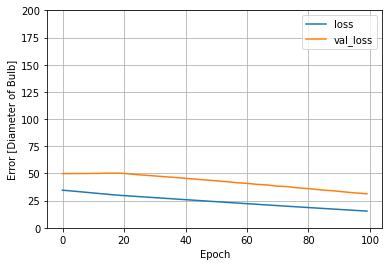

In [91]:
plot_loss(history)

Collect the results on the test set for later:

In [92]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

we implemented two linear models for single and multiple inputs above, now we will implement single-input and multiple-input DNN models. this involves expanding the model to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `NL_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [93]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(24, activation='relu'),
      layers.Dense(24, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'Number of leaves(NL)'` as input and `NL_normalizer` (defined earlier) as the normalization layer:

In [94]:
dnn_NL_model = build_and_compile_model(NL_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [95]:
dnn_NL_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_10 (Dense)            (None, 24)                48        
                                                                 
 dense_11 (Dense)            (None, 24)                600       
                                                                 
 dense_12 (Dense)            (None, 1)                 25        
                                                                 
Total params: 676
Trainable params: 673
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras `Model.fit`:

In [96]:
%%time
history = dnn_NL_model.fit(
    train_features['NL'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 1.82 s


This model does slightly better than the linear single-input `NL_model`:

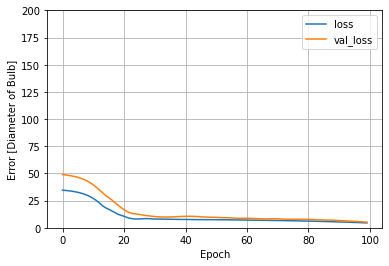

In [97]:
plot_loss(history)

If you plot the predictions as a function of `'NL'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [113]:
x = tf.linspace(0.0, 15,15)
y = dnn_NL_model.predict(x)

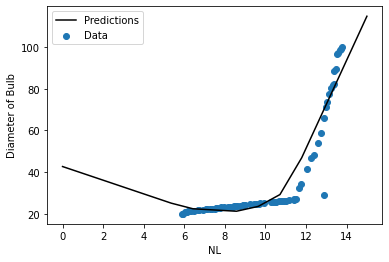

In [114]:
plot_NL(x, y)

Collect the results on the test set for later:

In [100]:
test_results['dnn_NL_model'] = dnn_NL_model.evaluate(
    test_features['NL'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Now we evaluate the DNN model using all the inputs. The model's performance slightly improves on the validation dataset.

In [101]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 6)                13        
 ion)                                                            
                                                                 
 dense_13 (Dense)            (None, 24)                168       
                                                                 
 dense_14 (Dense)            (None, 24)                600       
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                                                 
Total params: 806
Trainable params: 793
Non-trainable params: 13
_________________________________________________________________


In [102]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 1.86 s


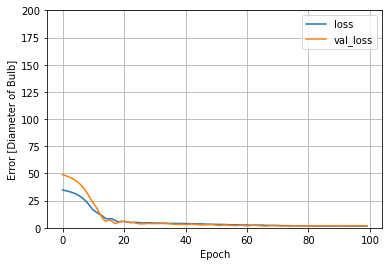

In [103]:
plot_loss(history)

Collect the results on the test set:

In [104]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [105]:
pd.DataFrame(test_results, index=['Mean absolute error [Diameter of Bulb]']).T

,Mean absolute error [Diameter of Bulb]
NL_model,18.608936
linear_model,18.690153
dnn_NL_model,5.332777
dnn_model,0.899249


These results match the validation error observed during training.

### Make predictions

Now we make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

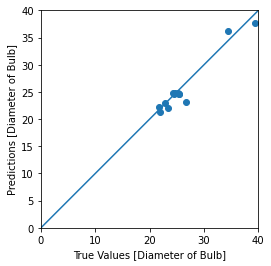

In [106]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Diameter of Bulb]')
plt.ylabel('Predictions [Diameter of Bulb]')
lims = [0, 40]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.
Now, we obtain the error distribution:

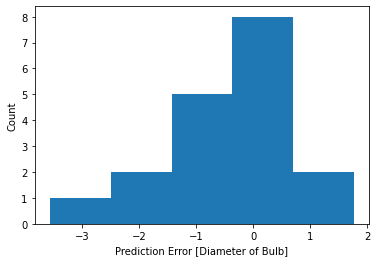

In [107]:
error = test_predictions - test_labels
plt.hist(error, bins=5)
plt.xlabel('Prediction Error [Diameter of Bulb]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [108]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


reloading the model, it gives identical output:

In [109]:
reloaded = tf.keras.models.load_model('dnn_model')
test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [110]:
(pd.DataFrame(test_results, index=['Mean absolute error [Diameter of Bulb]']).T)

,Mean absolute error [Diameter of Bulb]
NL_model,18.608936
linear_model,18.690153
dnn_NL_model,5.332777
dnn_model,0.899249
reloaded,0.899249
